In [1]:
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']

# load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle
from tqdm import tqdm

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
sys.path.append('../../')
import common as com
import pytorch_modeler as modeler

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# ML lib
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
#from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis


import librosa
import IPython
import librosa.display

# load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

# Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'

os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_by_GMM/config.yaml'

# load data

In [7]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [8]:
data_types = ['train', 'valid_source', 'valid_target']

In [9]:
def load_ext_data(machine_type):
    input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    ext_data = pd.read_pickle(input_path)
    
    return ext_data

# GMM AD by likelihood

## estimate

In [10]:
def load_gmm(machine_type, n_components):
    gmm = pd.read_pickle(f'{MODEL_DIR}/{machine_type}/{machine_type}_model_n={n_components}.pkl')
    return gmm

In [118]:
gmm = load_gmm(machine_types[0], 2)

In [124]:
gmm.predict_proba(X).shape

(600, 2)

In [11]:
# https://www.slideshare.net/ChihiroKusunoki/ss-98822807
# page.4

class GMM_estimator():
    def __init__(self, gmm, precisions_Cholesky=False):
        
        super(GMM_estimator, self).__init__()
        self.gmm = gmm
        self.K = gmm.n_components
        self.weights = gmm.weights_
        if precisions_Cholesky == True:
            self.precisions = gmm.precisions_cholesky_
        else:
            self.precisions = gmm.precisions_
        self.cov = gmm.covariances_
        self.means = gmm.means_
    
    def calc_energy(self, X):
        pred = self.gmm.predict_proba(X)
        sum_terms = []
        for k in range(self.K):
            # クラスタk番目の尤度
            likelihood = multivariate_normal.logpdf(X, mean=gmm.means_[k,:], cov=gmm.covariances_[k,:,:])
            # 混合比 * 尤度
            sum_term = likelihood * self.weights[k]
            sum_terms.append(sum_term)
        # 総和項
        sum_terms = np.array(sum_terms)
        # 負の対数
        log_term = sum_terms.sum(axis=0)
        energy = -np.log(log_term)
        
        return energy

2021-04-10 00:02:14,482 - 00_train.py - INFO - fan valid_source AUC : 0.5407222222222222


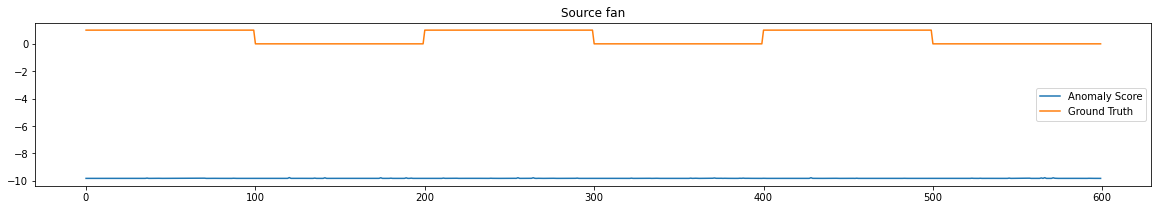

2021-04-10 00:02:20,907 - 00_train.py - INFO - fan valid_target AUC : 0.5893666666666666


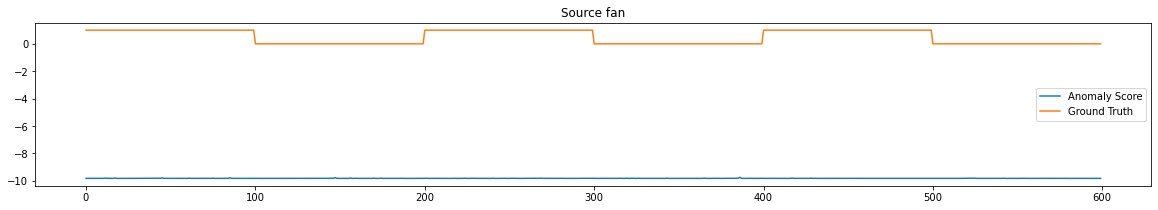

2021-04-10 00:02:31,006 - 00_train.py - INFO - gearbox valid_source AUC : 0.5005302888514567


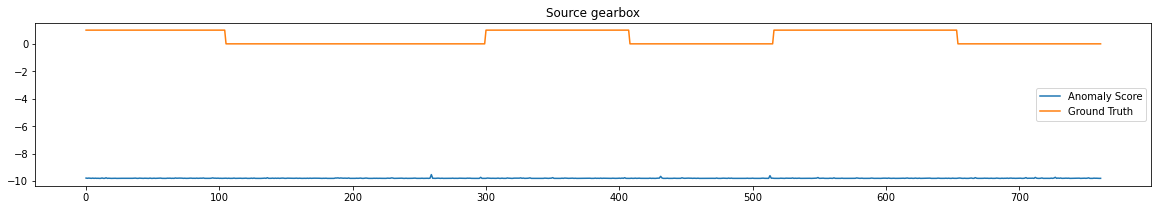

2021-04-10 00:02:37,818 - 00_train.py - INFO - gearbox valid_target AUC : 0.5172792417938049


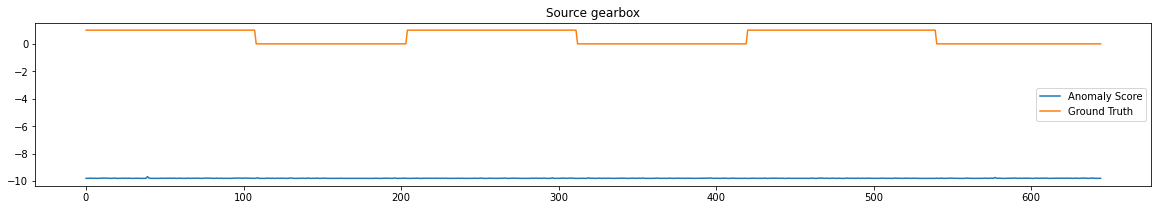

2021-04-10 00:02:47,252 - 00_train.py - INFO - pump valid_source AUC : 0.5846


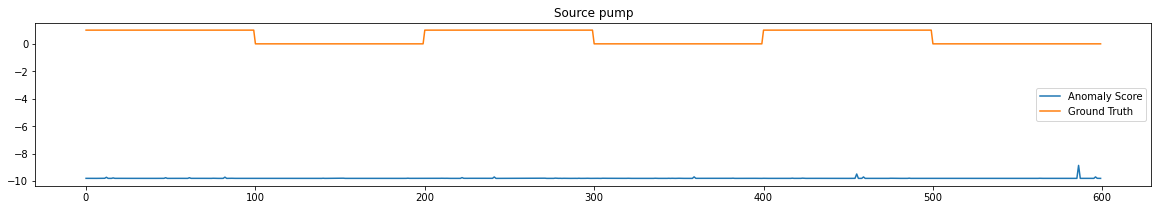

2021-04-10 00:02:53,607 - 00_train.py - INFO - pump valid_target AUC : 0.5237222222222222


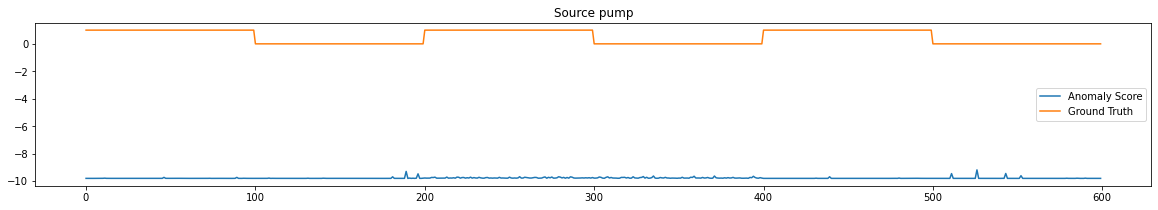

2021-04-10 00:03:03,191 - 00_train.py - INFO - slider valid_source AUC : 0.5787865840632342


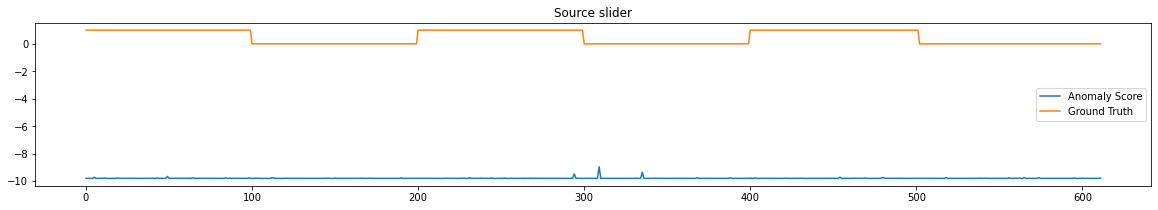

2021-04-10 00:03:09,765 - 00_train.py - INFO - slider valid_target AUC : 0.5910264900662252


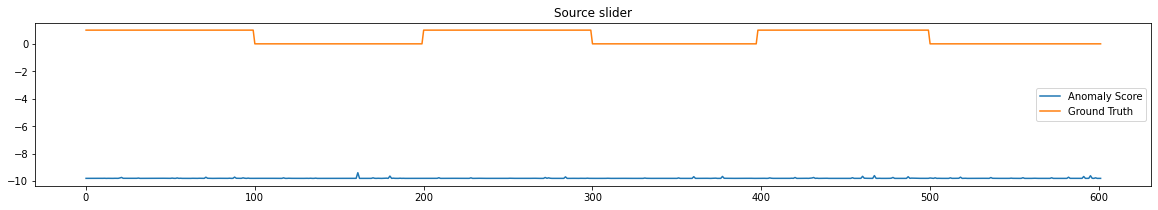

KeyboardInterrupt: 

In [12]:
n_components = 2

for machine_type in machine_types:
    # load data
    ext_data = load_ext_data(machine_type)
    # load gmm
    gmm = load_gmm(machine_type, n_components)
    # inference and calc AUC
    for phase in ['valid_source', 'valid_target']:
        features = ext_data[phase]['features']
        labels = ext_data[phase]['labels']
        est = GMM_estimator(gmm, precisions_Cholesky=False)
        anomaly_score = est.calc_energy(features)
        roc_auc = roc_auc_score(labels, anomaly_score)
        logger.info(f'{machine_type} {phase} AUC : {roc_auc}')
        # plot
        plt.figure(figsize=(20,3))
        plt.title(f'Source {machine_type}')
        plt.plot(anomaly_score, label='Anomaly Score')
        plt.plot(labels, label='Ground Truth')
        plt.legend()
        plt.show()

# GMM AD by weighted mahalanobis

In [13]:
def Calc_GMM_mahalanobis(gmm, features, labels):
    means = gmm.means_
    cov_inv = gmm.precisions_
    K = gmm.n_components
    pred_proba = gmm.predict_proba(features)
    mahalanobis_K = []
    for k in range(K):
        mahalanobis_k = [mahalanobis(sample, means[k,:], cov_inv[k,:,:]) for sample in features]
        mahalanobis_k = np.array(mahalanobis_k)
        mahalanobis_K.append(mahalanobis_k)
    mahalanobis_K = np.array(mahalanobis_K)
    anomaly_score = np.multiply(mahalanobis_K.T, pred_proba)
    anomaly_score = anomaly_score.sum(axis=1)
    
    return anomaly_score

2021-04-10 00:03:29,152 - 00_train.py - INFO - fan valid_source AUC : 0.5805


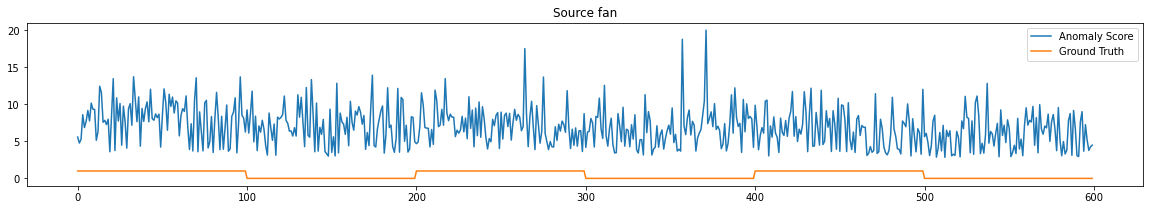

2021-04-10 00:03:33,659 - 00_train.py - INFO - fan valid_target AUC : 0.6065555555555555


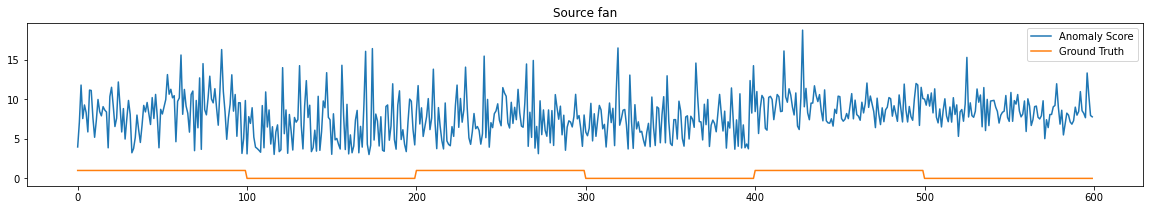

2021-04-10 00:03:39,792 - 00_train.py - INFO - gearbox valid_source AUC : 0.6225591116102065


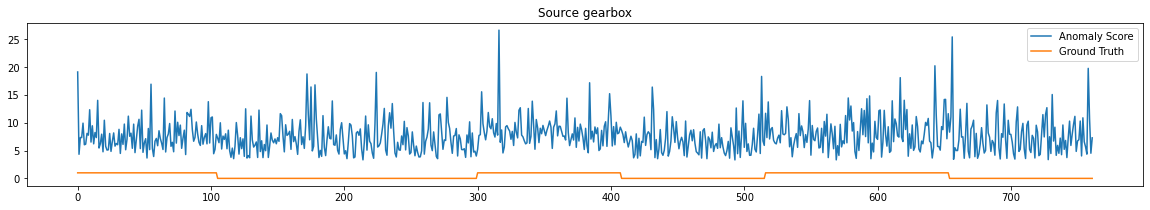

2021-04-10 00:03:44,787 - 00_train.py - INFO - gearbox valid_target AUC : 0.6986823855755896


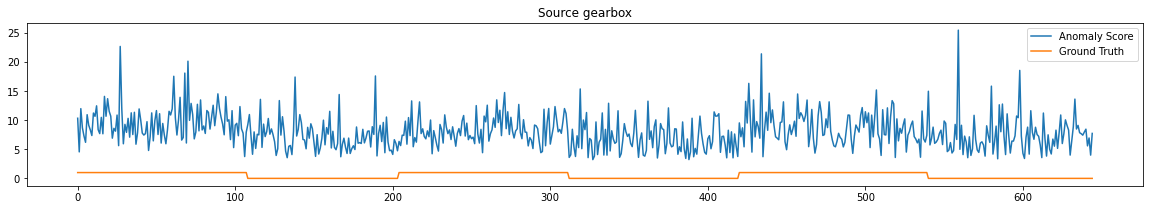

2021-04-10 00:03:49,620 - 00_train.py - INFO - pump valid_source AUC : 0.5964333333333334


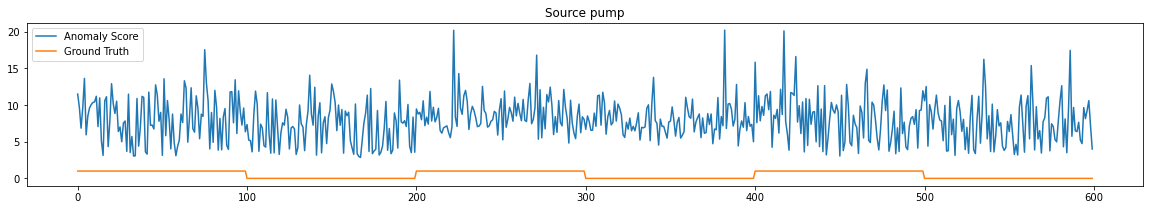

2021-04-10 00:03:54,648 - 00_train.py - INFO - pump valid_target AUC : 0.5336666666666667


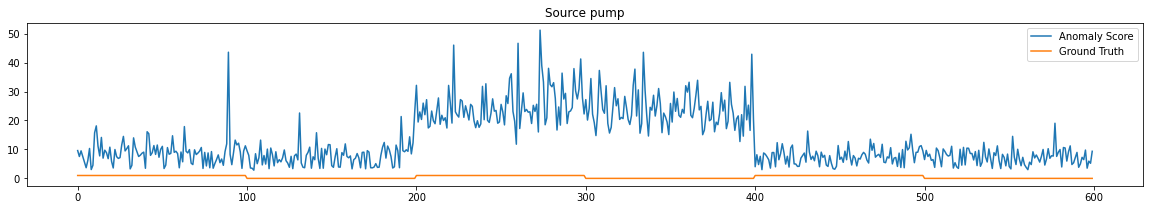

2021-04-10 00:04:00,805 - 00_train.py - INFO - slider valid_source AUC : 0.6709250160222175


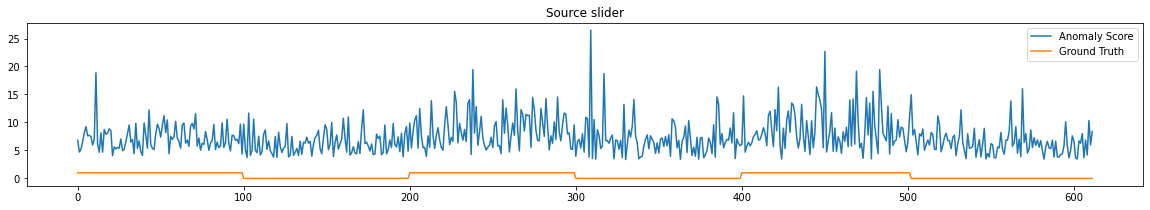

2021-04-10 00:04:05,512 - 00_train.py - INFO - slider valid_target AUC : 0.6192825607064019


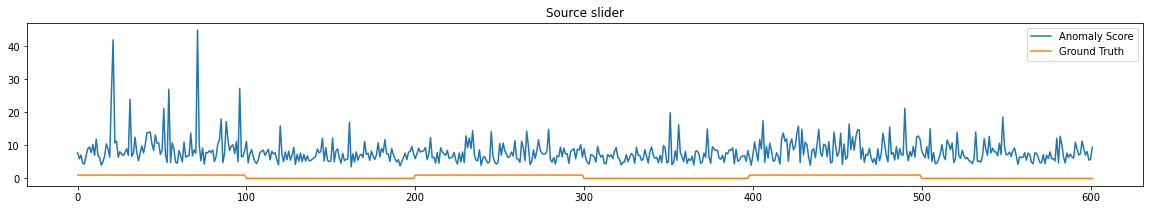

2021-04-10 00:04:10,397 - 00_train.py - INFO - ToyCar valid_source AUC : 0.6221444444444445


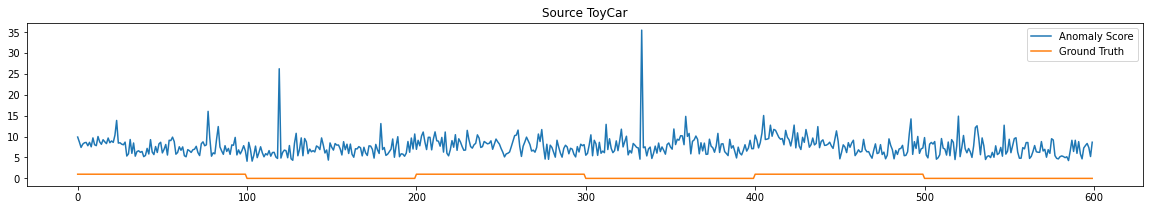

2021-04-10 00:04:15,529 - 00_train.py - INFO - ToyCar valid_target AUC : 0.5476000000000001


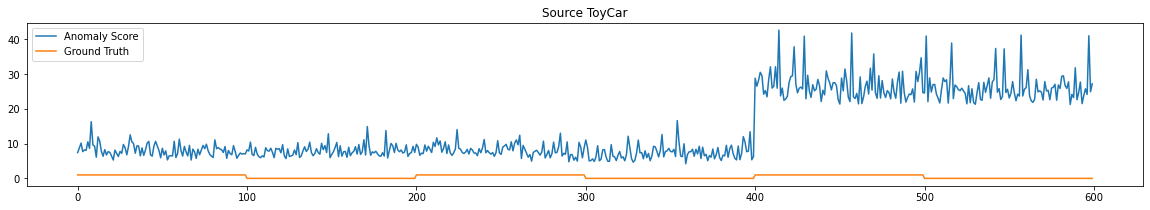

2021-04-10 00:04:23,323 - 00_train.py - INFO - ToyTrain valid_source AUC : 0.5802555555555555


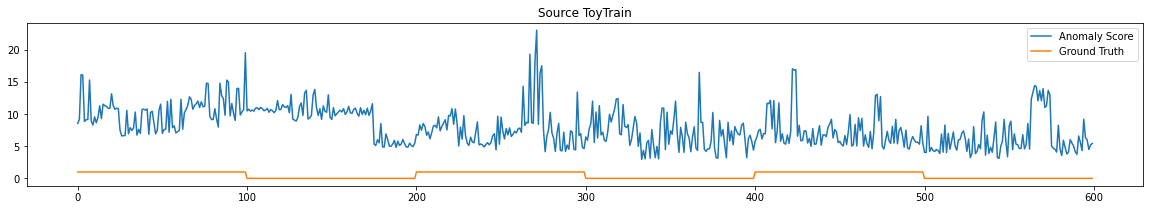

2021-04-10 00:04:28,133 - 00_train.py - INFO - ToyTrain valid_target AUC : 0.4806777777777778


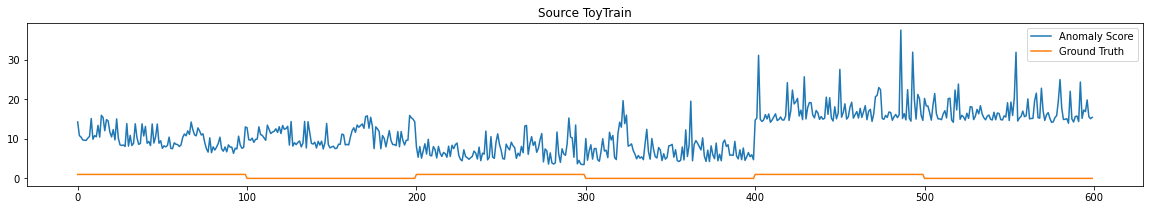

2021-04-10 00:04:36,544 - 00_train.py - INFO - valve valid_source AUC : 0.5328555555555555


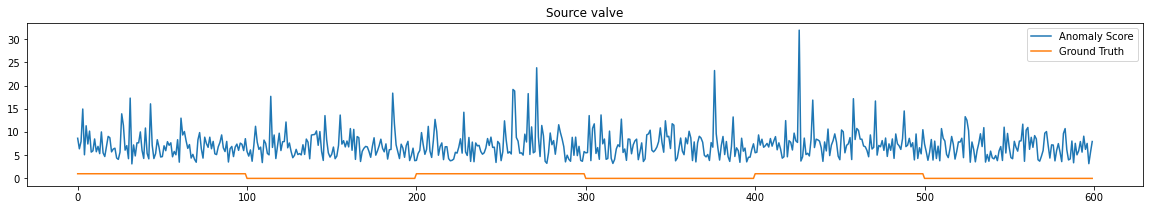

2021-04-10 00:04:41,056 - 00_train.py - INFO - valve valid_target AUC : 0.5482888888888888


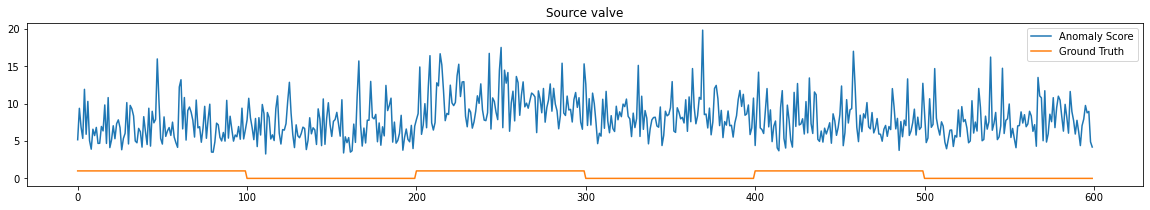

In [14]:
n_components = 2

for machine_type in machine_types:
    # load data
    ext_data = load_ext_data(machine_type)
    # load gmm
    gmm = load_gmm(machine_type, n_components)
    # inference and calc AUC
    for phase in ['valid_source', 'valid_target']:
        features = ext_data[phase]['features']
        labels = ext_data[phase]['labels']
        anomaly_score = Calc_GMM_mahalanobis(gmm, features, labels)
        roc_auc = roc_auc_score(labels, anomaly_score)
        logger.info(f'{machine_type} {phase} AUC : {roc_auc}')
        # plot
        plt.figure(figsize=(20,3))
        plt.title(f'Source {machine_type}')
        plt.plot(anomaly_score, label='Anomaly Score')
        plt.plot(labels, label='Ground Truth')
        plt.legend()
        plt.show()

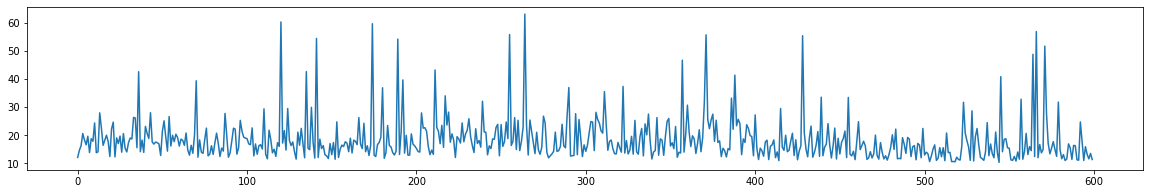

In [292]:
plt.figure(figsize=(20,3))
plt.plot(anomaly_score)